In [117]:
from collections import Counter
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import pickle 
import random
import json
import string
import os

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [7]:
raw_data = []
with open('./data/data.json') as f:
    for line in f:
        raw_data.append(json.loads(line))

labels = [int(d['annotation']['label'][0]) for d in raw_data]
text = [d['content'] for d in raw_data]

Counter(labels) #  label counts

Counter({0: 12179, 1: 7822})

In [4]:
data = {'text': text, 'label': labels }
raw_df = pd.DataFrame(data, columns=['text', 'label'])

In [86]:
def clean_text(text):
    
    lemmatizer = WordNetLemmatizer()
    punctuation = list(string.punctuation)
    punctuation.extend(['.', "’", ','])
    text = BeautifulSoup(text, 'html').text    
    filtered_text = ' '.join([word.lower() for word in text.split() if word not in stopwords.words('english')])
    filtered_text = ''.join([c for c in filtered_text if c not in punctuation])
    filtered_text = ''.join([c for c in filtered_text if not c.isdigit()])
    filtered_text = filtered_text.replace('-', ' ') 
    filtered_text = ' '.join([lemmatizer.lemmatize(w) for w in filtered_text.split()])
    return filtered_text

In [87]:
df = raw_df.copy()
df.text = df.text.apply(clean_text)

//anaconda/lib/python3.5/site-packages/bs4/__init__.py:336: UserWarning: "http://tinyurl.com/these-hats-are-damn-tradition" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda/lib/python3.5/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
//anaconda/lib/python3.5/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
//anaconda/lib/python3.5/site-packages/bs4/__init__.py:336: UserWarning: "http://www.e-castig.com/index.php?r=C1o6s" looks like a URL. Beautiful Soup is not an HTTP client. You shou

In [88]:
def sample_data(df, n):
    """
    display n samples data along with its labels
    """
    for label in set(df.label):
        subset = df[df.label == label]
        rand_idxs = [random.randint(0, subset.shape[0]) for i in range(n)]
        for idx in rand_idxs:
            print('Label: {}\nIndex: {}\t{}\n'.format(subset.iloc[idx]['label'], idx, subset.iloc[idx]['text']))            

In [96]:
sample_data(df, 4)

Label: 0
Index: 1711	ever bust as skate boarding

Label: 0
Index: 556	im boati need get leg shape i hate squeezing jean

Label: 0
Index: 11336	thing love first sight

Label: 0
Index: 2368	ate friday literally blew mindso goodbut fat louis type placemuch different vibe

Label: 1
Index: 4827	fuck

Label: 1
Index: 4973	a communist fucking dictatorship fuck che guevara and tshirts wear them

Label: 1
Index: 6564	i read wp wordpress damn hilarious

Label: 1
Index: 1533	direct church why dont you bloody well piss off



May have to clean the data more carefully, but for now I am going to just go ahead and create the simple BoW model using a logistic regression model.

### bag-of-words model

In [108]:
# experiment with CountVectorizer (bag-of-words model)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.text) #  bag-of-words representation
X = X.toarray()
y = df.label

print('{} {}'.format('Bag-of-words data shape', X.shape))

Bag-of-words data shape (20001, 16653)


In [133]:
def save_vectorizer(vectorizer, description):
    """ saves bag-of-words vectorizer in model assets folder
    
    Attributes
    -------------
    
        sklearn vectorizer: sklearn vectorizer
        description: vectorizer version/descriptor
    """
    
    with open(os.path.join(os.pardir, "model_assets/vectorizer_{}.pkl".format(description)), "wb") as f:
        pickle.dump(object, f)
    print('Vectorizer Saved.')

In [134]:
save_vectorizer(vectorizer, 'test_V.0.0')

Vectorizer Saved.


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

print('{:>15s} {}'.format('Train set shape', X_train.shape))
print('{:>15s} {}'.format('Test set shape', X_test.shape))

Train set shape (16000, 16653)
 Test set shape (4001, 16653)


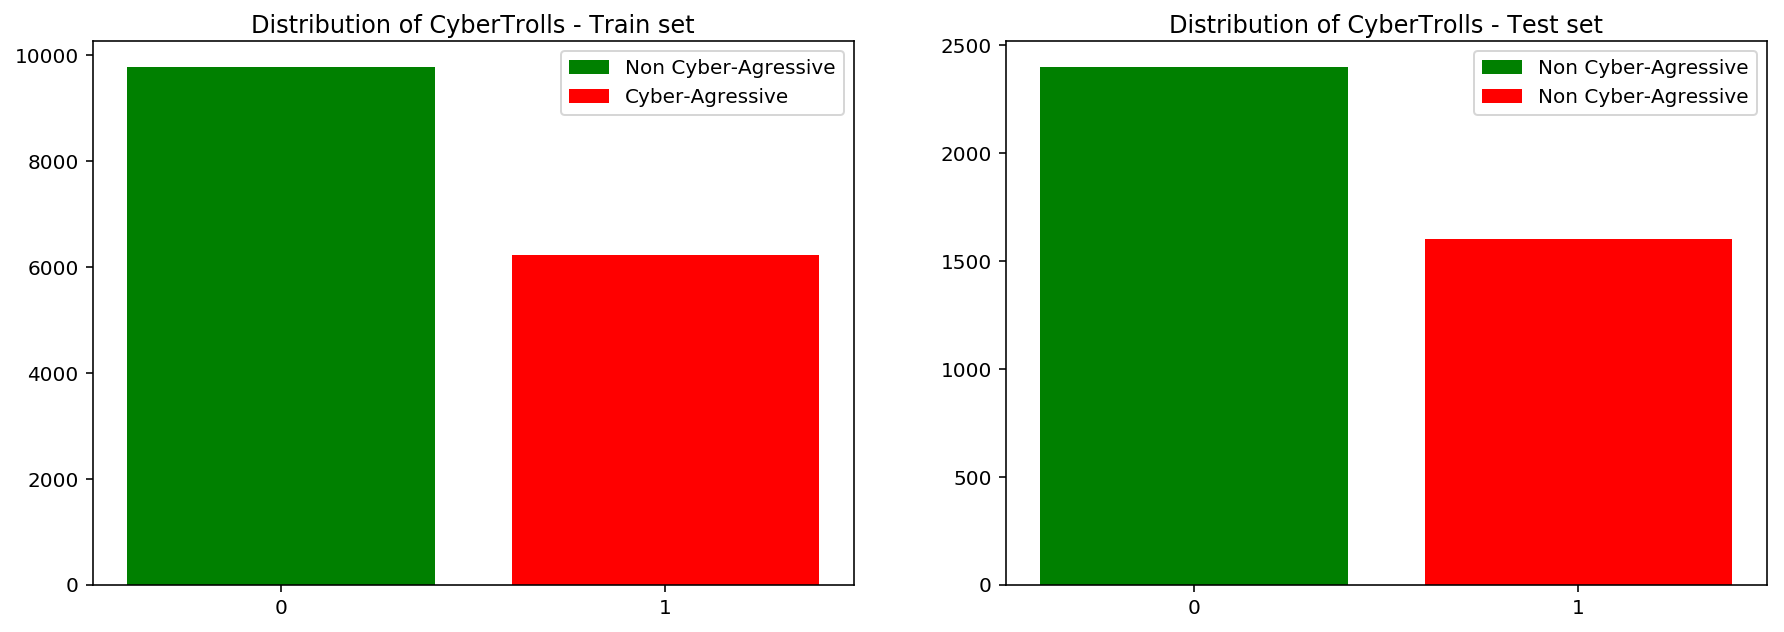

In [55]:
# Distribution of labels train/test sets
fig, axs = plt.subplots(1, 2, figsize=(15,5))

train_count = Counter(y_train)
axs[0].set_title('Distribution of CyberTrolls - Train set')
axs[0].bar(list(train_count.keys())[0],
           list(train_count.values())[0],
           align='center',
           color='g',
           label='Non Cyber-Agressive')
axs[0].bar(list(train_count.keys())[1],
           list(train_count.values())[1],
           align='center',
           color='r',
           label='Cyber-Agressive')
axs[0].set_xticks(list(set(y_train)))
axs[0].legend()


test_count = Counter(y_test)
axs[1].set_title('Distribution of CyberTrolls - Test set')
axs[1].bar(list(test_count.keys())[0],
           list(test_count.values())[0],
           align='center',
           color='g',
           label='Non Cyber-Agressive')
axs[1].bar(list(test_count.keys())[1],
           list(test_count.values())[1],
           align='center',
           color='r',
           label='Cyber-Agressive')
axs[1].set_xticks(list(set(y_test)))
axs[1].legend()

plt.show()

maybe try downsampling 'Non Cyber-Agressive' samples

Random forrest is not a good choice when modeling a high dimensional data. 

In [109]:
# logistic regression model 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix

In [112]:
clf = LogisticRegressionCV(Cs=[1, 10, 100], solver='saga', cv=3, n_jobs=2, verbose=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 187 seconds


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 180 seconds
max_iter reached after 178 seconds
max_iter reached after 186 seconds


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 204 seconds
max_iter reached after 192 seconds


KeyboardInterrupt: 

In [127]:
# save model and 

def save_model(clf, description):
    """ saves classifier in /model_assets folder
    
    Attributes
    -------------
    
        clf: Sklean classifier
        description: model version/descriptor
    """
    
    with open(os.path.join(os.pardir, "model_assets/model_{}.pkl".format(description)), "wb") as f:
        pickle.dump(object, f)
    print('Model Saved.')

In [128]:
save_model(clf, 'test_v.0.0')

Model Saved.


In [129]:
print('{:>20s} {:.2f}'.format('Train Accuracy:', clf.score(X_train, y_train)))
print('{:>20s} {:.2f}'.format('Test Accuracy:', clf.score(X_test, y_test)))

NotFittedError: This LogisticRegressionCV instance is not fitted yet

In [ ]:
confusion_matrix(y_test, clf.predict(X_test))